# Import necessary Libraries

In [50]:
from logging import warning
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import numpy as np
import torchvision.models as models
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# **1. Load Data & Transformation**


### **a) Transformation**

In [3]:
image_transforms = transforms.Compose([
    # data agumentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224,224)), # resize the image from 800x600 to 224x224
    transforms.ToTensor(), # converting to tensor object [matrix]
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]) # normalizing each RGB channels means and std
])

### **b) Load Data**

In [4]:
# define path for the data
# dataset_path  ="/content/drive/MyDrive/code Basics/project-3/dataset"
dataset_path  ="./dataset"
dataset = datasets.ImageFolder(root = dataset_path,transform=image_transforms)
len(dataset)

2315

In [5]:
#sub folders
num_classes = len(dataset.classes)
num_classes

6

In [43]:
class_names = dataset.classes

### **c) split Data**

In [7]:
# size of training 75% and test is 25%
train_size  = int(0.75*len(dataset))
val_size    = len(dataset)-train_size
train_size, val_size

(1736, 579)

In [8]:
# randomly spliting data
train_set , val_set = random_split(dataset, [train_size,val_size])

In [9]:
# making into batch size of 32
train_loader = DataLoader(train_set, batch_size = 32,shuffle=True)
val_loader   = DataLoader(val_set,batch_size= 32, shuffle=True)

In [10]:
for images, labels in train_loader:
  break

In [11]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

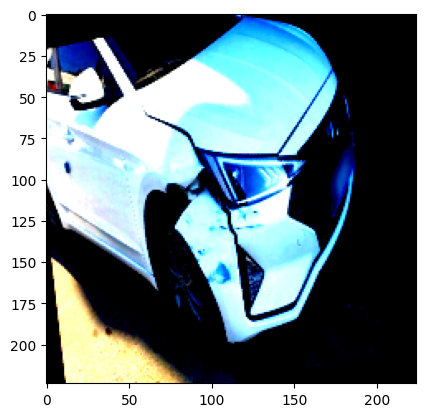

In [12]:
plt.imshow(images[2].permute(1,2,0))

In [13]:
labels[2]

tensor(0)

# **2. Model Training**


### **a) Model 1: CNN**

In [14]:
class CarClassification(nn.Module):
  def __init__(self,num_classes):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1,stride=1), # in(3,224,224)
        nn.ReLU(),
        nn.MaxPool2d(stride=2,kernel_size =2,padding=0), # (16,112,112)
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(stride=2,kernel_size =2,padding=0), # (32,56,56)
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(stride=2,kernel_size =2,padding=0),   #(64,28,28)
        nn.Flatten(),
        nn.Linear(64*28*28 ,512),
        nn.ReLU(),
        nn.Linear(512, num_classes)
    )
  def forward(self,x):
    x = self.network(x)
    return x

In [15]:
# model instance, criterion, optimizer
model = CarClassification(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [30]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")

    end = time.time()
    print(f"Execution time: {end - start} seconds")

    return all_labels, all_predictions

In [ ]:
all_labels, all_predictions = train_model(model,criterion,optimizer,epochs=1)

### **b) Model 2: CNN With Regularization**

In [ ]:
class CarClassificationWithRegularization(nn.Module):
  def __init__(self,num_classes):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1,stride=1),# in(3,224,224)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(stride=2,kernel_size =2,padding=0), # (16,112,112)
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(stride=2,kernel_size =2,padding=0), # (32,56,56)
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1,stride=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(stride=2,kernel_size =2,padding=0),   #(64,28,28)
        nn.Flatten(),
        nn.Linear(64*28*28 ,512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
  def forward(self,x):
    x = self.network(x)
    return x

In [ ]:
# model instance, criterion, optimizer
model = CarClassificationWithRegularization(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)

al1_labels, all_predictions = train_model(model,criterion,optimizer,epochs=10)

### **c) Model 3: Transfer Learning with EfficientNet**





In [23]:
class CarClassifierEfficientNet(nn.Module):
  def __init__(self,num_classes):
    super().__init__()
    self.model = models.efficientnet_b0(weights = 'DEFAULT')

    # Freezing the weights
    for param in self.model.parameters():
      param.requires_grad =  False

    in_features = self.model.classifier[1].in_features

    self.model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features, num_classes)
    )

  def forward(self,x):
    x = self.model(x)
    return x


In [24]:
# model instance, criterion, optimizer
model     = CarClassifierEfficientNet(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=0.001)

all_labels, all_predictions = train_model(model,criterion,optimizer,epochs=5)

Batch:10,Epoch:1,Loss:1.69
Batch:20,Epoch:1,Loss:1.60
Batch:30,Epoch:1,Loss:1.46
Batch:40,Epoch:1,Loss:1.30
Batch:50,Epoch:1,Loss:1.19
Batch:10,Epoch:2,Loss:1.20
Batch:20,Epoch:2,Loss:1.14
Batch:30,Epoch:2,Loss:1.16
Batch:40,Epoch:2,Loss:1.12
Batch:50,Epoch:2,Loss:1.17
Batch:10,Epoch:3,Loss:1.22
Batch:20,Epoch:3,Loss:1.07
Batch:30,Epoch:3,Loss:1.11
Batch:40,Epoch:3,Loss:0.94
Batch:50,Epoch:3,Loss:1.22
Batch:10,Epoch:4,Loss:1.00
Batch:20,Epoch:4,Loss:1.04
Batch:30,Epoch:4,Loss:1.14
Batch:40,Epoch:4,Loss:1.05
Batch:50,Epoch:4,Loss:0.95
Batch:10,Epoch:5,Loss:1.01
Batch:20,Epoch:5,Loss:0.83
Batch:30,Epoch:5,Loss:0.77
Batch:40,Epoch:5,Loss:0.86
Batch:50,Epoch:5,Loss:0.79
Epoch[5/5],Avg Loss: 0.9132
****Validataion Accuracy : 66.84%****
Execution time :296.4529490470886seconds.



### **d) Model 4: Transfer Learning with ResNet**

In [28]:
class CarClassifierResNet(nn.Module):
  def __init__(self,num_classes):
    super().__init__()
    self.model = models.resnet50(weights = 'DEFAULT')

    # Freeze all layers except the final fully connected layer
    for param in self.model.parameters():
      param.requires_grad =  False

    # unfreeze layer4 and fc layer
    for param in self.model.layer4.parameters():
      param.requires_grad  =True

    # replace the final fully connected layer
    self.model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(self.model.fc.in_features, num_classes)
    )

  def forward(self,x):
    x = self.model(x)
    return x


In [29]:
# model instance, criterion, optimizer
model     = CarClassifierResNet(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=0.001)

all_labels, all_predictions = train_model(model,criterion,optimizer,epochs=10)

Batch:10,Epoch:1,Loss:1.24
Batch:20,Epoch:1,Loss:0.90
Batch:30,Epoch:1,Loss:0.86
Batch:40,Epoch:1,Loss:0.70
Batch:50,Epoch:1,Loss:0.69
Batch:10,Epoch:2,Loss:0.54
Batch:20,Epoch:2,Loss:0.60
Batch:30,Epoch:2,Loss:0.41
Batch:40,Epoch:2,Loss:0.87
Batch:50,Epoch:2,Loss:0.39
Batch:10,Epoch:3,Loss:0.18
Batch:20,Epoch:3,Loss:0.45
Batch:30,Epoch:3,Loss:0.36
Batch:40,Epoch:3,Loss:0.30
Batch:50,Epoch:3,Loss:0.44
Batch:10,Epoch:4,Loss:0.31
Batch:20,Epoch:4,Loss:0.14
Batch:30,Epoch:4,Loss:0.39
Batch:40,Epoch:4,Loss:0.19
Batch:50,Epoch:4,Loss:0.49
Batch:10,Epoch:5,Loss:0.21
Batch:20,Epoch:5,Loss:0.05
Batch:30,Epoch:5,Loss:0.13
Batch:40,Epoch:5,Loss:0.13
Batch:50,Epoch:5,Loss:0.10
Batch:10,Epoch:6,Loss:0.18
Batch:20,Epoch:6,Loss:0.05
Batch:30,Epoch:6,Loss:0.10
Batch:40,Epoch:6,Loss:0.09
Batch:50,Epoch:6,Loss:0.04
Batch:10,Epoch:7,Loss:0.08
Batch:20,Epoch:7,Loss:0.02
Batch:30,Epoch:7,Loss:0.21
Batch:40,Epoch:7,Loss:0.14
Batch:50,Epoch:7,Loss:0.10
Batch:10,Epoch:8,Loss:0.02
Batch:20,Epoch:8,Loss:0.16
B

### **e) Model 5: Transfer Learning with ResNet with hyper tunning**

In [34]:
class CarClassifierResNet(nn.Module):
  def __init__(self,num_classes,dropout_rate):
    super().__init__()
    self.model = models.resnet50(weights = 'DEFAULT')

    # Freeze all layers except the final fully connected layer
    for param in self.model.parameters():
      param.requires_grad =  False

    # unfreeze layer4 and fc layer
    for param in self.model.layer4.parameters():
      param.requires_grad  =True

    # replace the final fully connected layer
    self.model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(self.model.fc.in_features, num_classes)
    )

  def forward(self,x):
    x = self.model(x)
    return x

In [35]:
# model instance, criterion, optimizer
model     = CarClassifierResNet(num_classes = num_classes,dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=0.005)

all_labels, all_predictions = train_model(model,criterion,optimizer,epochs=10)

Batch: 10, Epoch: 1, Loss: 1.22
Batch: 20, Epoch: 1, Loss: 0.82
Batch: 30, Epoch: 1, Loss: 0.77
Batch: 40, Epoch: 1, Loss: 0.85
Batch: 50, Epoch: 1, Loss: 0.90
Epoch [1/10], Avg Loss: 0.9476
*** Validation Accuracy: 73.75% ***
Batch: 10, Epoch: 2, Loss: 0.60
Batch: 20, Epoch: 2, Loss: 0.44
Batch: 30, Epoch: 2, Loss: 0.50
Batch: 40, Epoch: 2, Loss: 0.67
Batch: 50, Epoch: 2, Loss: 0.41
Epoch [2/10], Avg Loss: 0.5519
*** Validation Accuracy: 77.20% ***
Batch: 10, Epoch: 3, Loss: 0.33
Batch: 20, Epoch: 3, Loss: 0.42
Batch: 30, Epoch: 3, Loss: 0.39
Batch: 40, Epoch: 3, Loss: 0.49
Batch: 50, Epoch: 3, Loss: 0.55
Epoch [3/10], Avg Loss: 0.4366
*** Validation Accuracy: 78.76% ***
Batch: 10, Epoch: 4, Loss: 0.26
Batch: 20, Epoch: 4, Loss: 0.25
Batch: 30, Epoch: 4, Loss: 0.52
Batch: 40, Epoch: 4, Loss: 0.30
Batch: 50, Epoch: 4, Loss: 0.42
Epoch [4/10], Avg Loss: 0.3416
*** Validation Accuracy: 77.72% ***
Batch: 10, Epoch: 5, Loss: 0.40
Batch: 20, Epoch: 5, Loss: 0.72
Batch: 30, Epoch: 5, Loss: 0

# **3. Model Evaluation**

### **a) Model Evalutaion: Classifiaction Report**

In [45]:
report = classification_report(all_labels,all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.76      0.84       118
           1       0.68      0.87      0.77        92
           2       0.93      0.90      0.91       145
           3       0.83      0.68      0.75        79
           4       0.66      0.83      0.74        69
           5       0.81      0.79      0.80        76

    accuracy                           0.81       579
   macro avg       0.81      0.80      0.80       579
weighted avg       0.83      0.81      0.82       579



### **b) Model Evalutaion: Confusion Matrix**

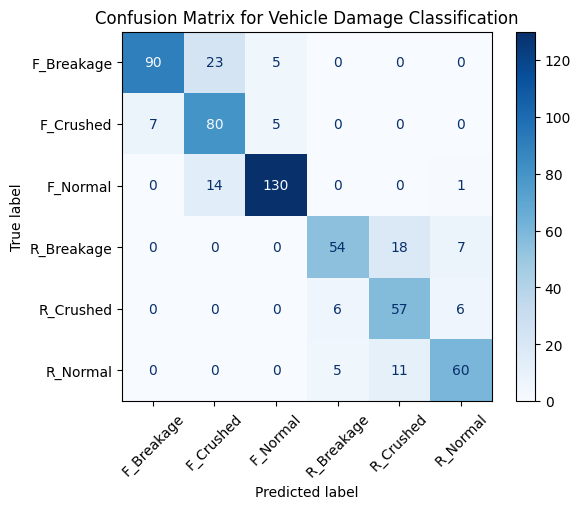

In [52]:
conf_matrix = confusion_matrix(all_labels,all_predictions,labels = np.arange(num_classes))
disp        = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = class_names)
disp.plot(cmap = plt.cm.Blues, xticks_rotation =45)
plt.title('Confusion Matrix for Vehicle Damage Classification')
plt.show()

In [54]:
torch.save(model.state_dict(),'saved_model.pth')